In [226]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [227]:
uploaded = files.upload()

Saving s2.png to s2.png


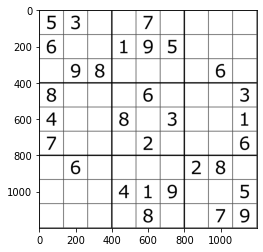

In [229]:
img = cv2.imread('s2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')

In [230]:
dst = cv2.GaussianBlur(gray, (1, 1), cv2.BORDER_DEFAULT)

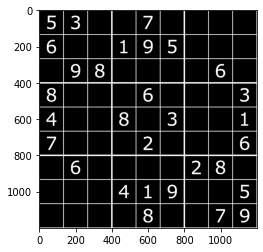

In [231]:
ret, thresh_inv = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh_inv, cmap = 'gray')

In [232]:
minLineLength = 100
maxLineGap = 60
lines = cv2.HoughLinesP(thresh_inv, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10,)
for l in lines:
    x1, y1, x2, y2 = l[0]
    cv2.line(img, (x1, y1) ,(x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
cv2.imwrite('hough.jpg', img)

True

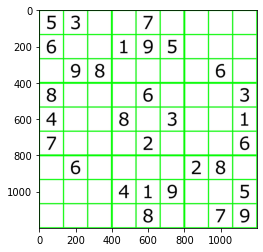

In [233]:
img_hough = cv2.imread('hough.jpg', 0)
img_show = cv2.imread('hough.jpg')
plt.imshow(img_show, cmap='gray')

In [234]:
contours, hierarchy = cv2.findContours(img_hough, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [235]:
cnt = contours[0]
max_area = cv2.contourArea(cnt)

for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)

In [236]:
max_area

1437601.0

In [237]:
epsilon = 0.01 * cv2.arcLength(cnt, True)
poly_approx = cv2.approxPolyDP(cnt, epsilon, True)

In [238]:
poly_approx

array([[[   0,    0]],

       [[   0, 1199]],

       [[1199, 1199]],

       [[1199,    0]]], dtype=int32)

In [239]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[1]
    rect[3] = pts[3]

    return rect

In [240]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
                    [0, 0], 
                    [0, maxHeight - 1], 
                    [maxWidth - 1, maxHeight - 1], 
                    [maxWidth - 1, 0]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [241]:
img_PT = four_point_transform(thresh_inv, poly_approx)

In [242]:
img_PT.shape

(1199, 1199)

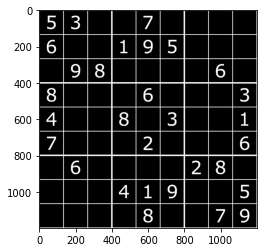

In [243]:
plt.imshow(img_PT, cmap='gray')

In [244]:
cv2.imwrite('img_PT.jpg', img)

True

In [245]:
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda

from keras.layers.normalization import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

from keras.datasets import mnist

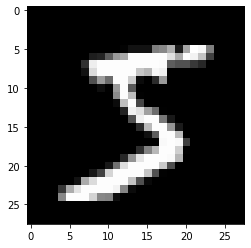

In [246]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.show()

In [247]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

In [248]:
x_train = x_train / 255
x_test = x_test / 255

In [249]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [250]:
model = Sequential()

layer_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape = (28, 28, 1))
layer_2 = Conv2D(64, kernel_size=3, activation='relu')
layer_3 = Flatten()
layer_4 = Dense(10, activation='softmax')

model.add(layer_1)
model.add(layer_2)
model.add(layer_3)
model.add(layer_4)

In [251]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [252]:
model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=5)

Epoch 1/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.2410 - accuracy: 0.9262 - val_loss: 0.0504 - val_accuracy: 0.9831
Epoch 2/5
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0453 - accuracy: 0.9862 - val_loss: 0.0426 - val_accuracy: 0.9869
Epoch 3/5
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0447 - val_accuracy: 0.9856
Epoch 4/5
1875/1875 [==============================] - 95s 51ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0548 - val_accuracy: 0.9845
Epoch 5/5
1875/1875 [==============================] - 93s 50ms/step - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.0441 - val_accuracy: 0.9876


In [253]:
model.save('digit_model.h5')

In [254]:
uploaded = files.upload()

Saving Sample.png to Sample (1).png


(28, 28)

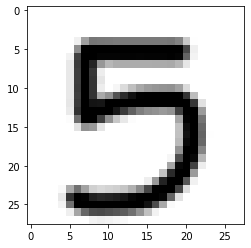

In [255]:
test_image = cv2.imread('Sample.png', 0)
plt.imshow(test_image, cmap='gray')
test_image.shape

In [256]:
from tensorflow.keras.models import load_model
new_model = load_model('digit_model.h5')

In [257]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

ret, thresh = cv2.threshold(test_image.copy(), 75, 255, cv2.THRESH_BINARY_INV)
resized_digit = cv2.resize(thresh, (28, 28))
resized_digit = resized_digit.reshape(1, 28, 28, 1)
resized_digit = tf.cast(resized_digit, tf.float32)
prediction = new_model.predict(resized_digit)
prediction

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [258]:
def prediction(test_image):
    classes = new_model.predict_classes(test_image)

    if classes == [[0]]:
        return 0
    elif classes == [[1]]:
        return 1
    elif classes == [[2]]:
        return 2
    elif classes == [[3]]:
        return 3
    elif classes == [[4]]:
        return 4
    elif classes == [[5]]:
        return 5
    elif classes == [[6]]:
        return 6
    elif classes == [[7]]:
        return 7
    elif classes == [[8]]:
        return 8
    elif classes == [[9]]:
        return 9

In [259]:
prediction(resized_digit)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


5

In [260]:
import tensorflow as tf
from PIL import Image

In [261]:
def getCellPositions(img_PT):
    img_PT = cv2.resize(img, (252, 252))

    cell_positions = []

    width = img_PT.shape[1]
    height = img_PT.shape[0]

    cell_width = width // 9
    cell_height = height // 9

    x1, x2, y1, y2 = 0, 0, 0, 0

    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1, x2, y1, y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions

In [262]:
def predictDigit(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[int(cell[2] + 2) : int(cell[3] - 3), int(cell[0] + 2) : int(cell[1] - 3)]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            if (w < 15 and x > 2) and (h < 25 and y > 2):
                pos.append((x, y, x + w, y + h))
                break
    if pos == []:
        result = 0
    if pos:
        img1 = img[(pos[0][1]) : (pos[0][3]), (pos[0][0]) : (pos[0][2])]
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        img1 = tf.cast(img1, tf.float32) 

        result = prediction(img1)
        
    return result

In [263]:
def extractSudokuDigits(img_PT):
    cell_digits, num = [], 0
    cells = getCellPositions(img_PT)

    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_PT)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i : i + n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

a = extractSudokuDigits(img_PT)
a

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[5, 3, 0, 0, 7, 0, 0, 0, 0],
 [6, 0, 0, 1, 9, 5, 0, 0, 0],
 [0, 9, 8, 0, 0, 0, 0, 6, 0],
 [8, 0, 0, 0, 6, 0, 0, 0, 3],
 [4, 0, 0, 8, 0, 3, 0, 0, 1],
 [7, 0, 0, 0, 2, 0, 0, 0, 6],
 [0, 6, 0, 0, 0, 0, 2, 8, 0],
 [0, 0, 0, 4, 1, 9, 0, 0, 5],
 [0, 0, 0, 0, 8, 0, 0, 7, 9]]

In [264]:
def printBoard(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("-----------------------")
        
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end = "")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end = "")

printBoard(a)

5 3 0  | 0 7 0  | 0 0 0
6 0 0  | 1 9 5  | 0 0 0
0 9 8  | 0 0 0  | 0 6 0
-----------------------
8 0 0  | 0 6 0  | 0 0 3
4 0 0  | 8 0 3  | 0 0 1
7 0 0  | 0 2 0  | 0 0 6
-----------------------
0 6 0  | 0 0 0  | 2 8 0
0 0 0  | 4 1 9  | 0 0 5
0 0 0  | 0 8 0  | 0 7 9


In [265]:
def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)
    return None

In [266]:
def valid(bo, num, pos):

    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y * 3, box_y * 3 + 3):
        for j in range(box_x * 3, box_x * 3 + 3):
            if bo[i][j] == num and (i, j) != pos:
                return False
    
    return True

In [267]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    
    for i in range(1, 10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            
            if solve(bo):
                return True
            
            bo[row][col] = 0
    
    return False

In [268]:
printBoard(a)
print("\n")
solve(a)
printBoard(a)

5 3 0  | 0 7 0  | 0 0 0
6 0 0  | 1 9 5  | 0 0 0
0 9 8  | 0 0 0  | 0 6 0
-----------------------
8 0 0  | 0 6 0  | 0 0 3
4 0 0  | 8 0 3  | 0 0 1
7 0 0  | 0 2 0  | 0 0 6
-----------------------
0 6 0  | 0 0 0  | 2 8 0
0 0 0  | 4 1 9  | 0 0 5
0 0 0  | 0 8 0  | 0 7 9


5 3 4  | 6 7 8  | 9 1 2
6 7 2  | 1 9 5  | 3 4 8
1 9 8  | 3 4 2  | 5 6 7
-----------------------
8 5 9  | 7 6 1  | 4 2 3
4 2 6  | 8 5 3  | 7 9 1
7 1 3  | 9 2 4  | 8 5 6
-----------------------
9 6 1  | 5 3 7  | 2 8 4
2 8 7  | 4 1 9  | 6 3 5
3 4 5  | 2 8 6  | 1 7 9


In [269]:
def detectEmptyCell(cell, img):
    pos = []
    img = cv2.resize(img, (252, 252))
    img = img[int(cell[2] + 2) : int(cell[3] - 3), int(cell[0] + 2) : int(cell[1] - 3)]
    contours, hierarchy = cv2.findContours(img.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) != 0:
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:
        return pos
    else:
        return 0

In [270]:
def placeSudokuDigits(img_PT):
    img_PT = cv2.resize(img_PT, (252, 252))
    img_color = cv2.resize(img, (252, 252))
    cells = getCellPositions(img_PT)
    n = 9
    cr = [cells[i : i + n] for i in range(0, len(cells), n)]
    digits = extractSudokuDigits(img_PT)
    solve(digits)
    for i in range(len(cr)):
        for j in range(len(cr[i])):
            pos = detectEmptyCell(cr[i][j], img_PT)
            digit_text = digits[i][j]
            if pos == []:
                cv2.putText(img_color, str(digit_text), ((cr[i][j][0] + 8), (cr[i][j][2] + 19)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                continue
    
    plt.imshow(img_color, cmap='gray')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


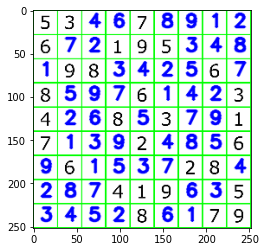

In [271]:
placeSudokuDigits(img_PT)